# Inverse Estimation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from abc import ABC, abstractmethod

import os, re, sys

import pickle as pkl
from pydemic import Pandemic, Outbreak

from scipy.stats import weibull_min
from skopt import Optimizer, dump, load
from skopt.plots import plot_objective, plot_evaluations, plot_convergence, partial_dependence
from skopt.space import Real

import seaborn as sns

from tabulate import tabulate


Bad key "text.kerning_factor" on line 4 in
/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

plt.rcParams['figure.figsize']=[32, 18]
plt.rcParams['font.size']=16
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 16

plt.style.use('seaborn-whitegrid')

### Setup

In [5]:
coronavirus_confirmed_df = pd.read_csv("../data/clean/coronavirus_confirmed_global.csv", index_col=0)
coronavirus_death_df = pd.read_csv("../data/clean/coronavirus_death_global.csv", index_col=0)
coronavirus_recovered_df = pd.read_csv("../data/clean/coronavirus_recovered_global.csv", index_col=0)
coronavirus_advanced_testing_policy_adopted = pd.read_csv("../data/clean/coronavirus_advanced_testing_policy_adopted.csv", index_col=0, squeeze=True)
coronavirus_latest_testing_per_thousand = pd.read_csv("../data/clean/coronavirus_latest_testing_per_thousand.csv", index_col=0, squeeze=True)

pandemic = Pandemic(
    "Coronavirus", 
    coronavirus_confirmed_df, 
    coronavirus_death_df, 
    recovery_curve=coronavirus_recovered_df, 
    advanced_testing_policy_adopted=coronavirus_advanced_testing_policy_adopted,
    latest_testing_per_thousand=coronavirus_latest_testing_per_thousand
)

# Estimation Helpers

### Estimator Helpers

In [6]:
def build_logger(verbose, prefix="default"):
    def _silent_log(*s): None
    def _log(*s): print(f"{prefix}:", *s)
        
    return _log if verbose else _silent_log

# Estimation

## Estimate Errors

In [7]:
def naive_error(realization, estimate):
    return realization - estimate

def scale_free_error(realization, estimate):
    errors = naive_error(realization, estimate)
    scale_coefficient = np.mean(np.abs(np.diff(realization))) if realization.shape[0] > 1 else realization[0]
    
    return errors / scale_coefficient

def mean_absolute_error(realization, estimate, error=naive_error):
    errors = error(realization, estimate)
    
    return np.mean(np.abs(errors))

## Estimator

In [17]:
class InvalidHazardRateException(Exception): pass

class OutbreakEstimator(ABC):
    """
    The OubreakEstimator abstract class provides a common foundation to build the different estimators devised for the study.
    
    The main parameters for the estimators are:
    
        - alpha: CFR
        - beta: Weibull shape
        - lambda: Weibull scale (called `lam` due to the Python primitive)
        
    There are also optional parameters:
        
        - verbose
        - random_state
        - warm_start, warm_start_min_deaths_observed: whether the model should only predict the daily fatality curve after X cumulative deaths have been seen.
        - error, cumulative_error: error method between realization and estimate to be used on the daily curve.
    
    """
    def __init__(self, outbreak, alpha=0.15, beta=2.5, lam=13, verbose=False, random_state=1, **kwds):
        self.outbreak = outbreak
        self.alpha, self.beta, self.lam = alpha, beta, lam
        self._build_hazard_rate()
        

        self._build_cases_and_deaths()
        
        self.verbose = verbose
        self.log = build_logger(verbose, prefix=outbreak.region)
        
        self.random_state = random_state
        
        self._update_model()
        
    def _build_cases_and_deaths(self):
        self.T = self.outbreak.duration
        self.cases = self.outbreak.epidemic_curve.values
        self.deaths = self.outbreak.fatality_curve.values
            
    def _build_hazard_rate(self, ppf_end=0.999, max_K=90):
        W = weibull_min(self.beta, scale=self.lam)
        self.K = min(int(W.ppf(ppf_end)), max_K)
        
        if self.K == 0: raise InvalidHazardRateException

        x = np.arange(self.K)
        
        # set fatality rate
        self.fatality_rate = W.cdf(x + 0.5) - W.cdf(x - 0.5)
        cumulative_fatality_rate = np.cumsum(self.fatality_rate)

        # set hazard rate
        self.hazard_rate = np.zeros(self.K)
        self.hazard_rate[0] = self.fatality_rate[0]
        self.hazard_rate[1:] = self.fatality_rate[1:] / (1 - cumulative_fatality_rate[:-1])
        
    @property
    def parameters(self):
        return (self.alpha, self.beta, self.lam)
        
    @parameters.setter
    def parameters(self, parameters):
        assert len(parameters) == 3 and type(parameters) == tuple and all(type(param) == float for param in parameters)
        
        if self.parameters == parameters: return
        
        self.alpha, self.beta, self.lam = parameters
        self._update_model()
        
    # Abstract Methods
    @abstractmethod
    def __str__(self):
        pass
    
    @abstractmethod
    def _update_model(self):
        self._build_hazard_rate()
    
    @abstractmethod
    def _estimate(self, **kwargs):
        pass

### Simulation-based Fatality Forecast

In [18]:
class SimulationFatalityEstimator(OutbreakEstimator):
    def __init__(self, *args, n_sims=1000, **kwargs):
        super().__init__(*args, **kwargs)
        self.n_sims = n_sims
        self._simulation_cache = {}
        
    def _simulate_outcomes(self, n_cases):
        probability_samples = np.random.rand(n_cases, self.K + 1)

        fatality_bitmask = probability_samples[:, 0] < self.alpha
        # argmax returns the index of the first "True" in an array of booleans
        fatality_delays = np.argmax(probability_samples[:, 1:] < self.hazard_rate, axis=1)

        return fatality_delays, fatality_bitmask
    
    def __str__(self):
        return "simulated"
    
    def _update_model(self):
        super()._update_model()

    def _estimate(self, overwrite=False):
        # perform calculations if necessary
        if overwrite or self.parameters not in self._simulation_cache:        
            fatalities = np.zeros((self.n_sims, self.T))

            # simulate every day of the outbreak
            for t, n_cases in enumerate(self.cases.astype(int)):
                fatality_delays, fatality_bitmask = self._simulate_outcomes(n_cases * self.n_sims)

                for sim in range(self.n_sims):
                    sim_ptr = n_cases * sim

                    # get fatality delays and fatality bitmask for sim 
                    sim_fatality_delays = fatality_delays[sim_ptr: sim_ptr + n_cases]
                    sim_fatality_bitmask = fatality_bitmask[sim_ptr: sim_ptr + n_cases]

                    # reduce fatality delays to fatality tolls per day
                    sim_fatality_days = np.bincount(sim_fatality_delays[sim_fatality_bitmask])
                    
                    # censor results to avoid index out of bounds
                    censoring = min(sim_fatality_days.shape[0], self.T - t)

                    # add fatality tolls per date to simulation counts
                    fatalities[sim, t:(t + censoring)] += sim_fatality_days[:censoring]

            # update caches
            self._simulation_cache[self.parameters] = fatalities
                
        return np.mean(self._simulation_cache[self.parameters], axis=0)

# class OutbreakDualSimulator(OutbreakEstimator):
#     def run(self, n_sims=1000):
#         self._simulate_outbreak(self.cases, self.alpha, self.hazard_rate, n_sims=n_sims)
    
#     @staticmethod
#     def _simulate_outcomes(n_cases, fatality_probability, fatality_hazard_rate, recovery_hazard_rate):
#         K = fatality_hazard_rate.shape[0]

#         probability_samples = np.random.rand(n_cases, K + 1)

#         fatality_bitmask = probability_samples[:, 0] < fatality_probability

#         fatality_outcome_days = np.argmax(probability_samples[fatality_probability, 1:] < fatality_hazard_rate, axis=1)
#         # use the inverse to make sure the two events are exclusive
#         recorvey_outcome_days = np.argmax(probability_samples[~fatality_probability, 1:] > 1 - recovery_hazard_rate, axis=1)

#         # assumption: if fatality/recovery occurs the same day, the fatality takes precendence
#         # fatality_bitmask = fatality_outcomes <= recovery_outcomes
#         # outcome_days = np.minimum(fatality_outcomes, recovery_outcomes)

#         return fatality_outcome_days, recorvey_outcome_days, fatality_bitmask

#     @staticmethod
#     def _simulate_outbreak(cases, fatality_probability, fatality_hazard_rate, recovery_hazard_rate, n_sims=100):
#         T = cases.shape[0]
#         K = hazard_rate.shape[0]

#         fatalities = np.zeros((n_sims, T))
#         recoveries = np.zeros((n_sims, T)) 

#         for t, n_cases in enumerate(cases.astype(int)):
#             fatality_outcome_days, recorvey_outcome_days, fatality_bitmask = simulate_cases(int(n_cases * n_sims), fatality_hazard_rate, recovery_hazard_rate)
#             n_recoveries = (~fatality_bitmask).sum()

#             for sim in range(n_sims):
#                 sim_outcome_days = outcome_days[n_cases * sim: n_cases * (sim + 1)]
#                 sim_fatality_bitmask = fatality_bitmask[n_cases * sim: n_cases * (sim + 1)]

#                 deaths_per_day = np.bincount(sim_outcome_days[sim_fatality_bitmask])
#                 censoring = min(deaths_per_day.shape[0], T - t)

#                 fatalities[sim, t:(t + censoring)] += deaths_per_day[:censoring]

#         return fatalities, recoveries

## Analytical Estimators

In [19]:
class BaseFatalityEstimator(OutbreakEstimator):
    def __str__(self):
        return "base"
    
    def _estimate(self):
        return self.alpha * np.sum(self.support_vectors, axis=1)

    def _update_model(self):
        super()._update_model()
        self._build_support_vectors()
        
    def _build_support_vectors(self):
        self.support_vectors = np.zeros((self.T, self.K))
        
        cumulative_survival_probability = np.cumprod(1 - self.hazard_rate)

        for t in range(1, self.T):
            for i in range(min(t, self.K)):
                self.support_vectors[t, i] = self.hazard_rate[i] * self.cases[t - i]

                if i >= 1:
                    self.support_vectors[t, i] *= cumulative_survival_probability[i - 1]

class DeltaFatalityEstimator(BaseFatalityEstimator):
    def __str__(self):
        return "delta"
    
    def _estimate(self):
        result = np.zeros(self.T)
        
        result[0] = self.deaths[0]
        result[1:] = [self.fatality_gradient(t) for t in range(self.T - 1)]
        
        return result
        
    def _update_model(self):
        super()._update_model()
        self._build_phi()
        
    def fatality_gradient(self, t):
        return self.alpha * (self.support_vectors[t + 1, 0] + (self.phi - 1).dot(self.support_vectors[t, :-1]))
    
    def _build_phi(self):
        if self.K < 2:
            raise InvalidHazardRateException

        self.phi = np.zeros(self.K - 1)

        for k in range(self.K - 1):
            self.phi[k] = self.fatality_rate[k + 1] / self.fatality_rate[k]

# Estimation Evaluation

## Optimizer

In [31]:
class NoResultException(Exception): pass

class OutbreakEstimatorOptimizer:
    # from previous study
    WUHAN_BETA = 1.8429282373343958
    WUHAN_LAMBDA = 10.018568258846706
    
    INITIAL_DIMENSIONS = [
        Real(0.01, 0.20), 
        Real(0.5, 10.0, WUHAN_BETA), 
        Real(1.0, 20.0, WUHAN_LAMBDA)
    ]
    
    RELAXED_DIMENSIONS = [
        Real(0.01, 1.0),
        Real(0.1, 20.0, WUHAN_BETA),
        Real(0.1, 100.0, WUHAN_LAMBDA)
    ]
    
    def __init__(self, estimator, n_random_starts=10, n_jobs=4, verbose=False, exploration_exploitation_coefficient=5, dimensions=None, resultpath="../results/coronavirus", **kwargs):
        self.estimator = estimator
        
        self._is_optimized = False 
        self._result = None 
        
        self.resultpath = os.path.join(resultpath, estimator.outbreak.region)
        
        self.dimensions = dimensions if dimensions else OutbreakEstimatorOptimizer.INITIAL_DIMENSIONS
        
        self.optimizer = Optimizer(
            acq_optimizer="lbfgs", 
            acq_func_kwargs={
                "xi": exploration_exploitation_coefficient, 
                "kappa": exploration_exploitation_coefficient
            },
            random_state=self.estimator.random_state, 
            dimensions=self.dimensions, 
            n_random_starts=n_random_starts,
            **kwargs
        )
        
        self.log = build_logger(verbose, prefix=f"{self.estimator.outbreak.region}.Optimizer")
        
    @property
    def dimensions_name(self):
        if self.dimensions == OutbreakEstimatorOptimizer.INITIAL_DIMENSIONS:
            return "initial"
        elif self.dimensions == OutbreakEstimatorOptimizer.RELAXED_DIMENSIONS:
            return "relaxed"
        
        return "custom"
        
    def run(self, score_fun, n_runs):
        self.log("Optimization started.")
        
        for iter_id in range(n_runs):
            parameters = self.optimizer.ask()
            
            score = score_fun(*parameters)
            
            self.optimizer.tell(parameters, score)
            self.log(f"Iteration #{iter_id}: {score} ({parameters[0]}, {parameters[1]}, {parameters[2]})")
            
        self.log("Optimization finished.")
        
        self._is_optimized = True
        self._result = self.optimizer.get_result()
            
    
    # return (or load) the skopt result for the current configuration
    @property
    def result(self):
        return self._result
            
    def load_result(self, configuration_prefix):
        filepath = os.path.join(self.resultpath, f"{configuration_prefix}_optimization_result.pkl")
        self.log(f"Loading results from {filepath}...")
        
        if os.path.isfile(filepath):
            self.log(f"Results found.")
            self._result = load(filepath)
        else:
            self.log(f"[WARN] Results not found.")
            
        return self._result
            
    def save_result(self, configuration_prefix):
        if self._result is None: 
            raise NoResultException
        
        if os.path.isdir(self.resultpath) is False:
            os.mkdir(self.resultpath)
            self.log(f"Created folder {self.resultpath}.")
            
        filepath = os.path.join(self.resultpath, f"{configuration_prefix}_optimization_result.pkl")
        self.log(f"Saving results to {filepath}...")
        
        dump(self._result, filepath)
        self.log(f"Results saved.")


## Validator

In [26]:
class NoTestingDataException(Exception): pass

class OutbreakValidator:
    def __init__(self, estimator, test_days=0, test_pre_peak=False, verbose=False, warm_start=True, warm_start_min_deaths_observed=10, cumulative_error=True, error=scale_free_error, **kwargs):
        self.estimator = estimator
        self.optimizer = OutbreakEstimatorOptimizer(estimator, verbose=verbose, **kwargs)
        
        self.test_pre_peak = test_pre_peak
        
        # perform a pre_peak test only if peak has not been reached
        if self.test_pre_peak and self.estimator.outbreak.is_peak_reached():
            outbreak_peak = self.estimator.outbreak.get_peak_id()
            
            assert 0 <= test_days and test_days < outbreak_peak
            self.test_split = outbreak_peak - test_days
            
        # otherwise, perform test at the end of the outbreak
        else:
            assert 0 <= test_days and test_days < estimator.T
            self.test_split = estimator.T - test_days
        
        # warm start
        self.warm_start = warm_start
        self.warm_start_min_deaths_observed = warm_start_min_deaths_observed
    
        self.t0 = self.estimator.outbreak.ffx_deaths(self.warm_start_min_deaths_observed)[0] if self.warm_start else 0
        assert self.t0 < self.test_split
        
        # error parameters
        self.error = error
        self.cumulative_error = cumulative_error
        
        # scoring functions
        self.training_score = self._build_score(self._training_slice)
        self.testing_score = self._build_score(self._testing_slice)
        
        self.log = build_logger(verbose, prefix=f"{self.estimator.outbreak.region}.Validator")
        
    @property
    def configuration_prefix(self):
        result = []
        
        result.append(self.estimator.__str__())
        result.append(str(self.test_split))
        
        if self.test_pre_peak:
            result.append("pre_peak")
            
        result.append("cumulative" if self.cumulative_error else "daily")
        result.append("scaled_error" if self.error == scale_free_error else "naive_error")
        
        if self.optimizer.dimensions_name != "initial":
            result.append(f"{self.optimizer.dimensions_name}_dimensions")
        
        return "_".join(result)
    
    @property
    def optimizer_result(self):
        return self.optimizer.result
    
    @property
    def best_estimate(self):
        self.estimator.parameters = self.best_training_parameters
        return self.estimator._estimate()
        
    @property
    def best_training_parameters(self):
        return tuple(self.optimizer_result.x) if self.optimizer_result else (None, None, None)
    
    @property
    def best_training_score(self):
        return self.optimizer_result.fun if self.optimizer_result else None
        
    def train(self, n_runs=100, cache=True):
        if self.optimizer.load_result(self.configuration_prefix) is None:
            self.log(f"Start training estimator until T={self.test_split}...")
            self.optimizer.run(self.training_score, n_runs)
            
            if cache:
                self.optimizer.save_result(self.configuration_prefix)
                
            self.log("Finish training estimator.")
            
        return self.best_training_parameters, self.best_training_score
            
    def test(self):
        if self.test_split == self.estimator.T:
            raise NoTestingDataException
            
        return self.testing_score(*self.best_training_parameters)
    
    def train_test_split(self, data):
        return self._training_slice(data), self._testing_slice(data)
        
    def _training_slice(self, data):
        return data[self.t0:self.test_split]
    
    def _testing_slice(self, data):
        return data[self.test_split:]
        
    def _build_score(self, _slice):
        def _score(alpha, beta, lam):
            try:
                self.estimator.parameters = (alpha, beta, lam)
                estimate = _slice(self.estimator._estimate())
                realization = _slice(self.estimator.deaths)
            
                if self.cumulative_error:
                    estimate = np.cumsum(estimate)
                    realization = np.cumsum(realization)

                return mean_absolute_error(realization, estimate, error=self.error)
                
            except InvalidHazardRateException:
                # return a much larger number to discourage the combination in later iterations
                return 1_000
        
        return _score

## Inspector

In [27]:
class OutbreakValidatorInspector:
    def __init__(self, validator, iteration_name, plotpath="../plots/coronavirus", savefigures=False):
        self.validator = validator
        self.estimator = validator.estimator
        
        self.plotpath = os.path.join(plotpath, iteration_name, self.estimator.outbreak.region)
        
        if os.path.isdir(self.plotpath) is False:
            if os.path.isdir(os.path.join(plotpath, iteration_name)) is False:
                os.mkdir(os.path.join(plotpath, iteration_name))
            os.mkdir(self.plotpath)
        
        self.savefigures = savefigures
        
    def _plot_fatality_estimate(self, ax, estimate, realization, title_prefix="Daily"):
        ax.set_title(f"{title_prefix} Fatality Estimate")
        ax.set_xlabel("Days since outbreak began (t)")
        ax.set_ylabel("Number of Deaths (d_t)")
        
        training_estimate, test_estimate = self.validator.train_test_split(estimate)
        training_realization, test_realization = self.validator.train_test_split(realization)
        
        ax.plot(np.append(training_realization, test_realization), label="realization")
        
        
        if test_estimate.shape[0] == 0:
            ax.plot(training_estimate, c='red', lw=3, label="estimate")
        else:
            
            if title_prefix == "Daily":
                ax.text(1, np.max(realization) * 0.9, f"Train MASE: {self.validator.best_training_score:.3}\nTest  MASE: {self.validator.test():.3}")
        
            ax.plot(np.append(training_estimate, test_estimate), c='red', lw=3, label="test estimate")
            ax.plot(training_estimate, c='orange', lw=3, label="training estimate")
            
        ax.legend()
        
    def _plot_case_fatality_density(self, ax):
        ax.set_title("Case Fatality Density")
        ax.set_xlabel("Days since infection confirmation (k)")
        ax.set_ylabel("Probability of Death | Death")
        
        ax.text(1, np.max(self.estimator.hazard_rate) * 0.5, 
                f"alpha={self.validator.best_training_parameters[0]:.3}\nbeta={self.validator.best_training_parameters[1]:.3}\nlambda={self.validator.best_training_parameters[2]:.3}")
        
        ax.plot(self.estimator.fatality_rate, label="Fatality density")
        ax.plot(self.estimator.hazard_rate, label="Hazard rate")
        
        ax.legend()
    
    def _plot_convergence(self, ax):
        ax.set_title("Convergence")
        ax.set_xlabel("MASE")
        ax.set_ylabel("Iterations")
        
        plot_convergence(self.validator.optimizer_result, dimensions=["alpha", "beta", "lambda"], ax=ax)
        
    def plot_estimate_summary(self):
        best_estimate = self.validator.best_estimate
        realization = self.estimator.deaths
        
        fig, axes = plt.subplots(ncols=2, nrows=2)
        fig.suptitle(f"{self.estimator.outbreak.region} - {self.validator.configuration_prefix}")
        
        self._plot_fatality_estimate(axes[0][0], best_estimate, realization)
        self._plot_fatality_estimate(axes[0][1], np.cumsum(best_estimate), np.cumsum(realization), title_prefix="Cumulative")
        self._plot_case_fatality_density(axes[1][0])
        self._plot_convergence(axes[1][1])
        
        if self.savefigures:
            filepath = os.path.join(self.plotpath, f"{self.validator.configuration_prefix}_estimate_summary.pdf")
            
            plt.savefig(filepath)
            
        plt.show()
        
    def plot_optimization_objective(self):
        axes = plot_objective(self.validator.optimizer_result, size=4, n_samples=100, minimum='expected_minimum', dimensions=OutbreakEstimatorInspector.PARAMETER_NAMES)
        
        plt.title(f"Parameter Partial Dependence - {self.validator.configuration_prefix}")
        
        if self.savefigures:
            filepath = os.path.join(self.plotpath, f"{self.validator.configuration_prefix}_optimization_objective.pdf")
            
            plt.savefig(filepath)
        
        plt.show()

### Naive Fitting

We naively fit the Top 20 countries considered over wide parameter bounds. This initial fit serves to prune those countries for which our model is not ideal. The scatterplot shown below displays two clear clusters of countries by CFR and MASE values around the 5% and 13% ranges. The following countries are removed from consideration due to inconsistencies in the data and poor fit with the model: "Saudi Arabia", "Turkey", "Russia", "Iran", "China". The main takeaway from this experiment is that calculating the error on the cumulative error trends leads to better performance. This should all be confirmed in the next experiment.

In [760]:
top20_countries = pandemic.get_top_regions(top_n=20, exclude=["Saudi Arabia", "Turkey", "Russia", "Iran", "China"])

In [482]:
top20_estimates_df = pd.DataFrame(columns=["region", "cumulative_error", "cutoff", "alpha", "beta", "lambda", "Training MASE"])

In [284]:
ptr = 0

for region, outbreak in pandemic.get_outbreaks(top20_countries).items():
    print(f"Fitting for {region}: full")
    
    # Full (Daily)
    model = BaseFatalityEstimator()
    model.fit(outbreak)
    model.save_result()
    
    top20_estimates_df.loc[ptr, :] = [region, False, 0, *model.best_parameters, model.best_parameters_error]
    ptr += 1
    
    # Full (Cumulative)
    model = BaseFatalityEstimator(cumulative_error=True)
    model.fit(outbreak)
    model.save_result()
    
    top20_estimates_df.loc[ptr, :] = [region, True, 0, *model.best_parameters, model.best_parameters_error]
    ptr += 1
    
    print(f"Fitting for {region}: 3-days")
    # 3-days (Daily)
    model = BaseFatalityEstimator(T=3)
    model.fit(outbreak)
    model.save_result()
    
    top20_estimates_df.loc[ptr, :] = [region, False, 3, *model.best_parameters, model.best_parameters_error]
    ptr += 1
    
    # 3-days (Cumulative)
    model = BaseFatalityEstimator(T=3, cumulative_error=True)
    model.fit(outbreak)
    model.save_result()
    
    top20_estimates_df.loc[ptr, :] = [region, True, 3, *model.best_parameters, model.best_parameters_error]
    ptr += 1
    
    print(f"Fitting for {region}: 7-days")
    # 7-days (Daily)
    model = BaseFatalityEstimator(T=7)
    model.fit(outbreak)
    model.save_result()
    
    top20_estimates_df.loc[ptr, :] = [region, False, 7, *model.best_parameters, model.best_parameters_error]
    ptr += 1
    
    # 7-days (Cumulative)
    model = BaseFatalityEstimator(T=7, cumulative_error=True)
    model.fit(outbreak)
    model.save_result()
    
    top20_estimates_df.loc[ptr, :] = [region, True, 7, *model.best_parameters, model.best_parameters_error]
    ptr += 1

Fitting for Belgium: full
Fitting for Belgium: 3-days
Fitting for Belgium: 7-days
Fitting for Brazil: full
Fitting for Brazil: 3-days
Fitting for Brazil: 7-days
Fitting for Canada: full
Fitting for Canada: 3-days
Fitting for Canada: 7-days
Fitting for Chile: full
Fitting for Chile: 3-days
Fitting for Chile: 7-days
Fitting for Ecuador: full
Fitting for Ecuador: 3-days
Fitting for Ecuador: 7-days
Fitting for France: full
Fitting for France: 3-days
Fitting for France: 7-days
Fitting for Germany: full
Fitting for Germany: 3-days
Fitting for Germany: 7-days
Fitting for India: full
Fitting for India: 3-days
Fitting for India: 7-days
Fitting for Ireland: full
Fitting for Ireland: 3-days
Fitting for Ireland: 7-days
Fitting for Italy: full
Fitting for Italy: 3-days
Fitting for Italy: 7-days
Fitting for Mexico: full


/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting for Mexico: 3-days
Fitting for Mexico: 7-days


/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting for Netherlands: full


/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting for Netherlands: 3-days
Fitting for Netherlands: 7-days


/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting for Pakistan: full
Fitting for Pakistan: 3-days
Fitting for Pakistan: 7-days
Fitting for Peru: full
Fitting for Peru: 3-days
Fitting for Peru: 7-days
Fitting for Portugal: full
Fitting for Portugal: 3-days
Fitting for Portugal: 7-days
Fitting for Spain: full
Fitting for Spain: 3-days


/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting for Spain: 7-days
Fitting for Sweden: full


/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

Fitting for Sweden: 3-days
Fitting for Sweden: 7-days


/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting for Switzerland: full
Fitting for Switzerland: 3-days
Fitting for Switzerland: 7-days
Fitting for US: full
Fitting for US: 3-days
Fitting for US: 7-days
Fitting for United Kingdom: full
Fitting for United Kingdom: 3-days
Fitting for United Kingdom: 7-days


In [849]:
# top20_estimates_df.to_csv("../results/coronavirus/top20_estimates.csv")
top20_estimates_df = pd.read_csv("../results/coronavirus/top20_estimates.csv", index_col=["region", "cumulative_error", "cutoff"])

### Selected Countries Fitting

Goals

- [x] Tighter Dimension Constraints. The current bounds are wide by design, in order to allow for a wide a variety of optimal solutions. We want to find a tighter bound, especially when it comes to the Weibull parameters for consistency in solutions, as well as the certainty that the CFR represents the same quantity across all countries. In its current state, there are several sample points that provide a decent estimate: $\alpha$ and $\lambda$ values can balance each other out in order to provide similar looking curves (in it's current state). The new constraints are $\alpha \in (,)$, $\beta \in (,)$ and $\lambda \in (,)$
- [ ] Global CFR
- [ ] Cumulative vs Daily Errors
- [ ] Pre-peak vs pre-end precision (parameter differences)

In [14]:
selected_countries = {'Belgium', 'Canada', 'France', 'Germany', 'Ireland', 'Italy', 'Netherlands', 'Portugal', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'US', 'United Kingdom'}
estimate_result_df = pd.DataFrame(columns=["region", "cumulative_error", "test_days", "test_pre_peak", "alpha", "beta", "lambda", "Training MASE", "Testing MASE"])

In [1027]:
ptr = 0

for region, outbreak in pandemic.get_outbreaks(selected_countries).items():
    for test_days in [7, 14]:
        for cumulative_error in [True, False]:
            for test_pre_peak in [True, False]:
                estimator = BaseFatalityEstimator(outbreak, verbose=True)
                validator = OutbreakValidator(estimator, test_days=test_days, test_pre_peak=test_pre_peak, cumulative_error=cumulative_error, verbose=True)

                best_params, best_training_score = validator.train(n_runs=200)
                
#                 testing_score = validator.test()

#                 estimate_result_df.loc[ptr, :] = [region, cumulative_error, test_days, test_pre_peak, *best_params, best_training_score, testing_score]

#                 ptr += 1

Belgium.Optimizer: Loading results from ../results/coronavirus/Belgium/base_59_pre_peak_cumulative_scaled_error_optimization_result.pkl...
Belgium.Optimizer: Results found.
Belgium.Optimizer: Loading results from ../results/coronavirus/Belgium/base_93_cumulative_scaled_error_optimization_result.pkl...
Belgium.Optimizer: Results found.
Belgium.Optimizer: Loading results from ../results/coronavirus/Belgium/base_59_pre_peak_daily_scaled_error_optimization_result.pkl...
Belgium.Optimizer: Results found.


KeyboardInterrupt: 

In [1028]:
# estimate_result_df.set_index(["region", "cumulative_error", "test_days", "test_pre_peak"], drop=True).to_csv("../results/coronavirus/selected_estimate_result.csv")
estimate_result_df = pd.read_csv("../results/coronavirus/selected_estimate_result.csv", index_col=["region", "cumulative_error", "test_days", "test_pre_peak"])

In [ ]:

fatality_rates = []
param_df = estimate_result_df.xs(True, level=1).xs(7, level=1).xs(False, level=1)[["alpha", "beta", "lambda"]]

In [1065]:
param_df

,alpha,beta,lambda
region,,,
Belgium,0.180970,4.990902,7.528180
Canada,0.102785,3.063273,14.861577
France,0.174910,0.502305,6.201425
Germany,0.043996,4.640447,12.362725
Ireland,0.069999,2.899569,8.399510
Italy,0.142826,1.579095,4.335312
Netherlands,0.131736,3.651708,4.469970
Portugal,0.047037,0.937901,7.774379
Spain,0.117102,0.966816,3.215053


In [1096]:
from matplotlib import cm
colormap = cm.tab20.colors

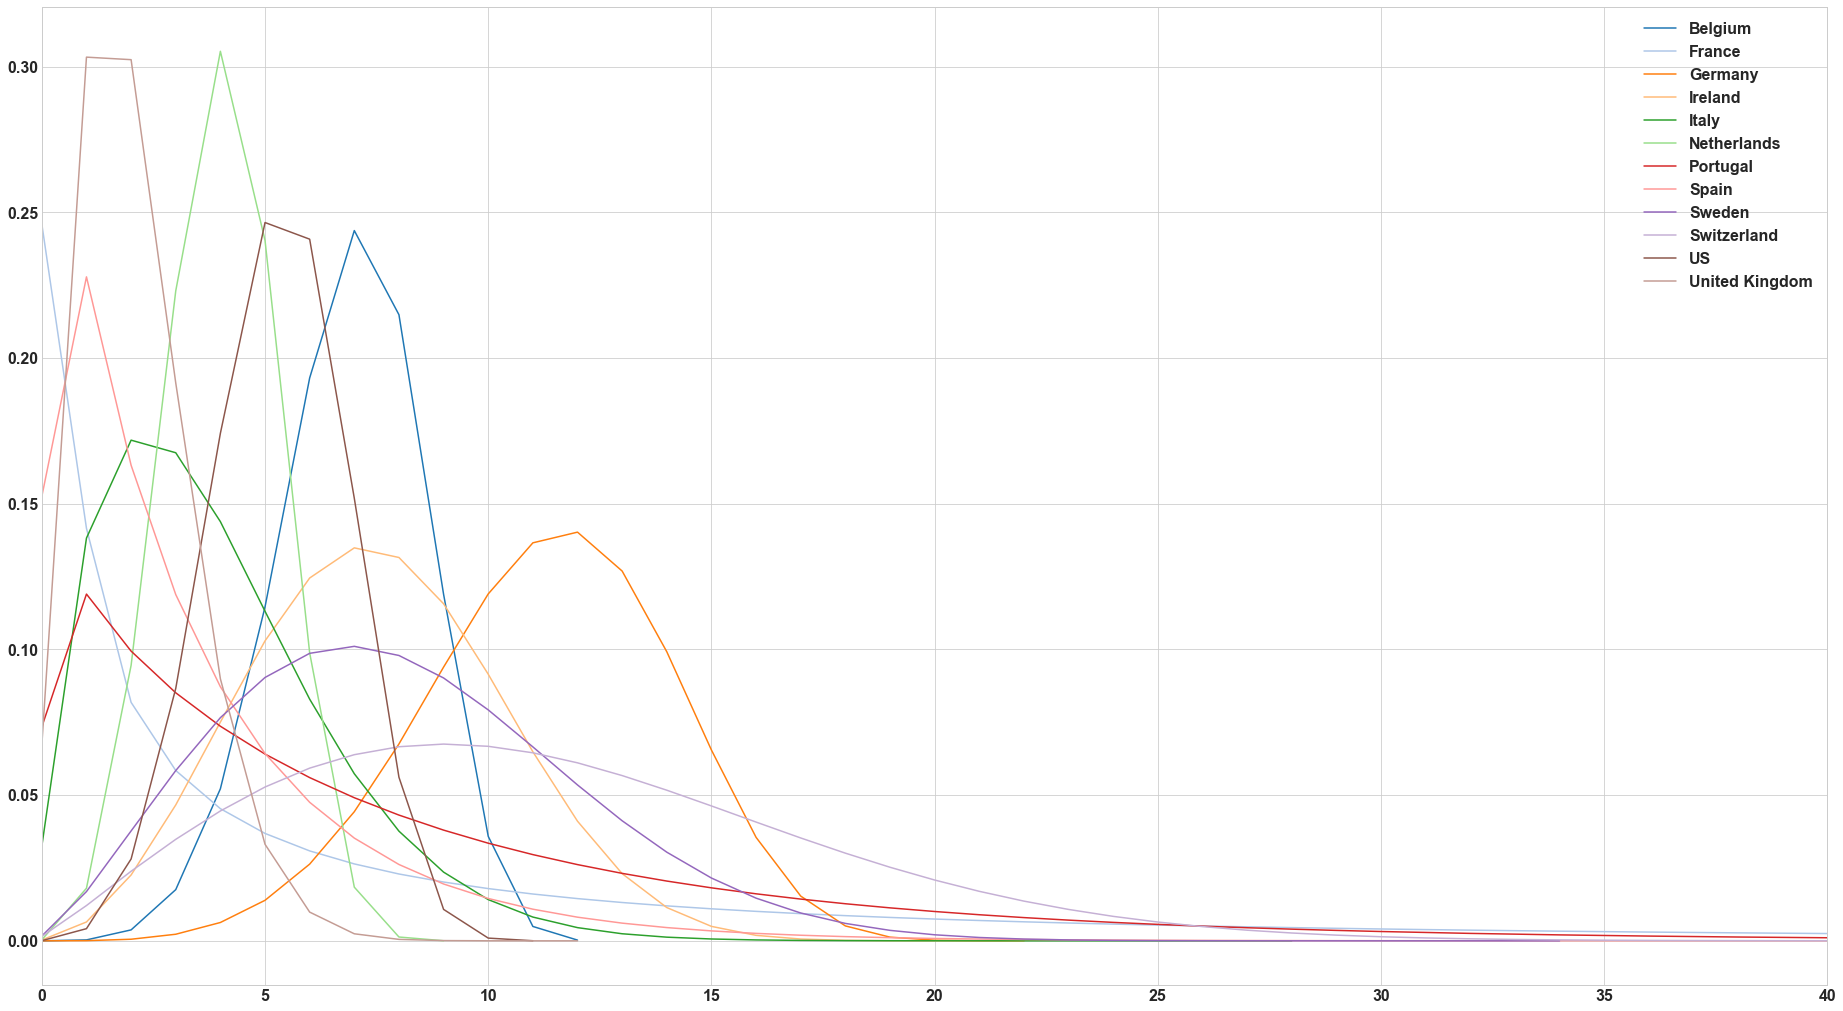

In [1105]:
ax = plt.gca()
ax.set_xlim(left=0, right=40)

fatality_rates = []

ptr = 0 
for region, outbreak in pandemic.get_outbreaks({'Belgium', 'France', 'Germany', 'Ireland', 'Italy', 'Netherlands', 'Portugal', 'Spain', 'Sweden', 'Switzerland', 'US', 'United Kingdom'}).items():
    params = param_df.loc[region]
    
    estimator = BaseFatalityEstimator(outbreak, alpha=params.alpha, beta=params.beta, lam=params["lambda"], verbose=True)
    
    ax.plot(estimator.fatality_rate, label=region, c=colormap[ptr])
    ptr += 1
    
plt.legend()
plt.show()

### Improved dimensions

In [28]:
selected_countries = {'Belgium', 'Canada', 'France', 'Germany', 'Ireland', 'Italy', 'Netherlands', 'Portugal', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'US', 'United Kingdom'}
improved_bound_estimate_result_df = pd.DataFrame(columns=["region", "test_days", "test_pre_peak", "alpha", "beta", "lambda", "MASE"])

In [30]:
ptr = 0

for region, outbreak in pandemic.get_outbreaks(selected_countries).items():
    estimator = BaseFatalityEstimator(outbreak, verbose=True)
    validator = OutbreakValidator(
        estimator, 
        test_days=0, 
        test_pre_peak=False, 
        cumulative_error=True, 
        verbose=True, 
        dimensions=OutbreakEstimatorOptimizer.RELAXED_DIMENSIONS, 
        exploration_exploitation_coefficient=30
    )

    best_params, best_training_score = validator.train(n_runs=1000)
    improved_bound_estimate_result_df.loc[ptr, :] = [region, *best_params, best_training_score]

                
#                 testing_score = validator.test()

#                 estimate_result_df.loc[ptr, :] = [region, cumulative_error, test_days, test_pre_peak, *best_params, best_training_score, testing_score]

#                 ptr += 1

Belgium.Optimizer: Loading results from ../results/coronavirus/Belgium/base_100_cumulative_scaled_error_relaxed_dimensions_optimization_result.pkl...
Belgium.Optimizer: [WARN] Results not found.
Belgium.Validator: Start training estimator until T=100...
Belgium.Optimizer: Optimization started.
Belgium.Optimizer: Iteration #0: 1000 (0.9972129628294801, 26.703623388364598, 0.24231111933338845)
Belgium.Optimizer: Iteration #1: 140.26897627941528 (0.9990501101709035, 0.4114505823285299, 1.5478974396671026)
Belgium.Optimizer: Iteration #2: 25.607272556101513 (0.39403163375038747, 5.529926598285641, 64.06446628303947)
Belgium.Optimizer: Iteration #3: 110.58819442657818 (0.8478478075191571, 0.6533659306969202, 3.746661682023669)
Belgium.Optimizer: Iteration #4: 39.848009136269454 (0.4490183648417612, 0.3957069542839507, 4.010899007934542)
Belgium.Optimizer: Iteration #5: 134.93238162869878 (0.9148224043334409, 1.5476556542181095, 1.9592763739852783)
Belgium.Optimizer: Iteration #6: 78.0860816

Belgium.Optimizer: Iteration #75: 24.485192775239085 (0.02227658928787207, 0.1366602236378642, 17.461192728702787)
Belgium.Optimizer: Iteration #76: 23.841764688291565 (0.056844985246659256, 39.74026513400642, 17.577480491687176)
Belgium.Optimizer: Iteration #77: 62.22165774695013 (0.9278552896996584, 0.16728652601170826, 100.0)
Belgium.Optimizer: Iteration #78: 18.048401258660917 (0.10338701016730698, 33.24813059718008, 15.297633690940778)
Belgium.Optimizer: Iteration #79: 21.12264186742036 (0.2543879363340539, 39.762807647139184, 15.051657517895492)
Belgium.Optimizer: Iteration #80: 24.194800308500135 (0.029388110438708315, 19.733047620991613, 14.964941183212847)
Belgium.Optimizer: Iteration #81: 25.145137911738615 (0.030755269093632076, 0.49322418102336973, 100.0)
Belgium.Optimizer: Iteration #82: 24.43223206597625 (0.030505998984251298, 26.65839885125938, 14.33485141863536)
Belgium.Optimizer: Iteration #83: 67.26089132819772 (0.9323830754929409, 0.1277036021421353, 100.0)
Belgium.O

Belgium.Optimizer: Iteration #149: 18.511730498526116 (0.9971876140303382, 34.04744325449783, 37.64276947311172)
Belgium.Optimizer: Iteration #150: 21.382945135981707 (0.07158795735151141, 2.3367243972121075, 25.136719146033357)
Belgium.Optimizer: Iteration #151: 24.809583668809932 (0.3502548941170211, 2.3852146997805, 100.0)
Belgium.Optimizer: Iteration #152: 53.41069894588706 (0.9425801402533988, 2.3419269921860373, 23.41753187439497)
Belgium.Optimizer: Iteration #153: 22.80847787075674 (0.5190416965850414, 0.16841054927843013, 99.9826652409872)
Belgium.Optimizer: Iteration #154: 26.892308852954457 (0.5221610011609924, 37.56158746621132, 4.1301909091228355)
Belgium.Optimizer: Iteration #155: 26.244460557436014 (0.12802776288524526, 2.384966022548005, 100.0)
Belgium.Optimizer: Iteration #156: 26.951831231501345 (0.17218858671759446, 33.66096749737744, 4.122740692676654)
Belgium.Optimizer: Iteration #157: 25.23150335889403 (0.018095430794646504, 2.3979110436402498, 19.107506537038486)


Belgium.Optimizer: Iteration #228: 5.846190418329499 (0.24675018957641706, 0.7250587017640143, 31.3991507879692)
Belgium.Optimizer: Iteration #229: 5.611593496747633 (0.7924212505356771, 0.8328877164804063, 100.0)
Belgium.Optimizer: Iteration #230: 26.12124460746812 (0.46823053563924655, 0.7694574902154473, 16.623626661443794)
Belgium.Optimizer: Iteration #231: 6.011818315591025 (0.8162570677953346, 0.8423542844632143, 100.0)
Belgium.Optimizer: Iteration #232: 26.76474300240359 (0.6437863892802179, 5.155746755140584, 100.0)
Belgium.Optimizer: Iteration #233: 3.177157835814472 (0.36610355900059816, 0.7938955798631767, 38.3836418240034)
Belgium.Optimizer: Iteration #234: 109.37172636757701 (0.907978878605288, 0.1, 0.1)
Belgium.Optimizer: Iteration #235: 4.12792656791525 (0.565151479867406, 0.800731964322066, 100.0)
Belgium.Optimizer: Iteration #236: 26.674150106686355 (0.7132076285378266, 0.7984784256009028, 38.831264307481376)
Belgium.Optimizer: Iteration #237: 21.26652806647854 (0.1918

Belgium.Optimizer: Iteration #303: 26.344507660826192 (0.0136480539098392, 6.871240441735042, 29.31050264786372)
Belgium.Optimizer: Iteration #304: 24.891828053711 (0.0170504782390808, 0.676846854407337, 11.641082034974)
Belgium.Optimizer: Iteration #305: 9.709179752278782 (0.719615494472441, 0.6466631996533029, 99.97458028284122)
Belgium.Optimizer: Iteration #306: 20.01604330041649 (0.06751326161581432, 0.10081149315438653, 99.76196646031669)
Belgium.Optimizer: Iteration #307: 23.74342865916386 (0.05543714195550702, 0.5292122544086448, 98.70915573201854)
Belgium.Optimizer: Iteration #308: 21.372953071389936 (0.716714541735481, 39.54721962894523, 10.209618678086049)
Belgium.Optimizer: Iteration #309: 11.550385346607902 (0.3956363256815232, 1.8090511883506821, 47.43349460470388)
Belgium.Optimizer: Iteration #310: 25.391925833535367 (0.01145400746450255, 1.1082568067562217, 8.376115971359782)
Belgium.Optimizer: Iteration #311: 25.475479346658044 (0.014498354040284251, 9.718629603252074, 

Belgium.Optimizer: Iteration #375: 26.86491499522396 (0.44031049354364743, 0.10399762372807125, 7.5113882279029545)
Belgium.Optimizer: Iteration #376: 14.192108261558444 (0.3277231543111815, 0.3151083102103907, 9.88564445632165)
Belgium.Optimizer: Iteration #377: 23.665950191705665 (0.28338377905770334, 0.6856298602228905, 1.2186364689380464)
Belgium.Optimizer: Iteration #378: 16.01145238819522 (0.47056255593160423, 18.440178204017545, 21.941728915084802)
Belgium.Optimizer: Iteration #379: 21.393203740491302 (0.032457350557653655, 1.9452605613022673, 1.3389803658284087)
Belgium.Optimizer: Iteration #380: 10.474643658847723 (0.2650302586018737, 3.287430494142369, 2.176944302897373)
Belgium.Optimizer: Iteration #381: 12.027246625612877 (0.3573848732032808, 7.509380175334133, 2.5133086719117363)
Belgium.Optimizer: Iteration #382: 26.735072530213724 (0.02401966045804905, 9.648711256909403, 1.948430012869521)
Belgium.Optimizer: Iteration #383: 27.059914210884816 (0.9842840516237409, 39.9375

Belgium.Optimizer: Iteration #447: 12.093016800389385 (0.5371785257927083, 3.4134037329705778, 33.12255282337812)
Belgium.Optimizer: Iteration #448: 19.05228801843379 (0.39150913312376195, 4.369220343571741, 2.4531190294490006)
Belgium.Optimizer: Iteration #449: 23.33527362403069 (0.022620780645954814, 1.1262407734516782, 0.25144060587191147)
Belgium.Optimizer: Iteration #450: 12.335126257244871 (0.21302181614682855, 0.7301687310902173, 0.1584235282893847)
Belgium.Optimizer: Iteration #451: 1000 (0.016508295177237675, 1.2056515755944746, 0.13576601812432837)
Belgium.Optimizer: Iteration #452: 25.404141050281215 (0.01, 3.079253756949318, 3.6366750164862274)
Belgium.Optimizer: Iteration #453: 27.071457011445663 (0.01, 40.0, 3.805812943103559)
Belgium.Optimizer: Iteration #454: 25.40620520862861 (0.01, 3.0331584113677885, 3.631656883763311)
Belgium.Optimizer: Iteration #455: 27.0167914352956 (0.01, 40.0, 3.8138681129728935)
Belgium.Optimizer: Iteration #456: 61.33670323312251 (0.634939866

Belgium.Optimizer: Iteration #526: 23.69483267216385 (0.028834818325686795, 0.10199361197863015, 16.09856302482013)
Belgium.Optimizer: Iteration #527: 26.245403889363878 (0.010270873719567817, 0.49307682450578705, 50.870002031513515)
Belgium.Optimizer: Iteration #528: 27.014762452228425 (0.010265616031571738, 39.86036961143411, 47.104512154059705)
Belgium.Optimizer: Iteration #529: 25.243166043156755 (0.010585721433652374, 0.43401654635316494, 1.1607397077829908)
Belgium.Optimizer: Iteration #530: 19.101134048493485 (0.9962915829655659, 9.650695706635535, 48.52431881345916)
Belgium.Optimizer: Iteration #531: 25.327516689496118 (0.015899908348305535, 0.10465985014608434, 45.457751859380394)
Belgium.Optimizer: Iteration #532: 24.41718150788128 (0.020249362235448792, 0.10186034239776072, 2.1298547155052328)
Belgium.Optimizer: Iteration #533: 24.58580163012258 (0.014964792784023056, 2.6047406916171663, 2.3670384076997353)
Belgium.Optimizer: Iteration #534: 25.367529531938455 (0.01223225486

Belgium.Optimizer: Iteration #598: 26.319424965830095 (0.011673433113632049, 0.4795147190467225, 97.38522601807882)
Belgium.Optimizer: Iteration #599: 22.94797093895738 (0.9798762824196509, 0.6585052158355295, 97.34952761363105)
Belgium.Optimizer: Iteration #600: 13.902780360339486 (0.08993987311213635, 0.1005262854531803, 0.10195095084731166)
Belgium.Optimizer: Iteration #601: 25.99936157353865 (0.010159073605190905, 0.5118347957260178, 21.744391123326547)
Belgium.Optimizer: Iteration #602: 25.3911967100757 (0.015374074099844766, 0.10642878573833672, 47.088272445275706)
Belgium.Optimizer: Iteration #603: 25.749079086463915 (0.012726955545656754, 9.260053561155269, 6.462888421439665)
Belgium.Optimizer: Iteration #604: 23.281294671468444 (0.025335622241984296, 0.10014264243539052, 0.11272228433746181)
Belgium.Optimizer: Iteration #605: 117.86342078529616 (0.9924577438718234, 0.1012568709771982, 0.21301596803548115)
Belgium.Optimizer: Iteration #606: 25.53608125179183 (0.0120333608038239

Belgium.Optimizer: Iteration #670: 24.56962782745729 (0.01383745454848644, 0.8470759060247663, 1.0916104753110627)
Belgium.Optimizer: Iteration #671: 25.989389128673036 (0.014203521873605058, 0.3483605283114048, 98.82644255480962)
Belgium.Optimizer: Iteration #672: 27.036000899892628 (0.9988903025633246, 8.804374590672962, 98.4504895425013)
Belgium.Optimizer: Iteration #673: 22.49523080102896 (0.9761850921428644, 39.955907112322706, 7.670961913821879)
Belgium.Optimizer: Iteration #674: 40.13436624272321 (0.9992157039433821, 5.908012955411406, 26.91613814606765)
Belgium.Optimizer: Iteration #675: 25.227782416702933 (0.011144141013957512, 0.27557042766974105, 0.7375142646481853)
Belgium.Optimizer: Iteration #676: 27.07145699112132 (0.9886114042649955, 39.1891488066073, 96.512199255321)
Belgium.Optimizer: Iteration #677: 24.45172489313757 (0.020237114559063126, 0.10239054138274548, 2.726492105050339)
Belgium.Optimizer: Iteration #678: 24.84904981166916 (0.016505117719527146, 0.35316571543

KeyboardInterrupt: 